In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt
#!pip install geopandas==0.14.4

In [2]:
df = pd.read_csv("../data/Canada_Gravity_2018.csv", comment='/')

In [3]:
# Pull out Longitude and Latitude
xy = df[['X', 'Y']].values

Text(0, 0.5, 'Latitude')

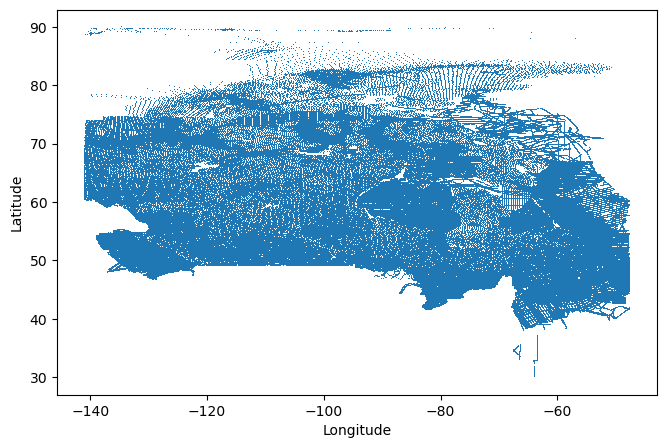

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(xy[:,0], xy[:,1], ',')
ax.set_aspect(1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.set_title(day)

In [5]:
df_grouped_day = df.groupby('DAY')

In [6]:
# get unique days
days = list(df_grouped_day.groups.keys())

In [7]:
# Explort gravity data obtained at'01-APR-1965'
day = days[0]
df_grouped_day.get_group(day)[['X', 'Y', 'ADJG', 'DAY']].to_csv('fime_demo.csv', index=False)

In [8]:
from ipywidgets import widgets, interact
def foo(day):
    df_tmp_group = df_grouped_day.get_group(day)[['X', 'Y', 'ADJG', 'DAY']]
    xy_tmp = df_tmp_group[['X', 'Y']].values
    
    
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    ax.plot(xy[:,0], xy[:,1], ',')
    ax.plot(xy_tmp[:,0], xy_tmp[:,1], 'ro')
    ax.set_aspect(1)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(day)
interact(foo, day=widgets.Select(options=days))

interactive(children=(Select(description='day', options=('01-APR-1965', '01-APR-1969', '01-APR-1970', '01-APR-…

<function __main__.foo(day)>

In [9]:
number_of_points = xy.shape[0]
number_of_points / 1e5

7.16957

In [10]:
gdf = gpd.read_file("../data/hudsonbay_polygon.shp")

<Axes: >

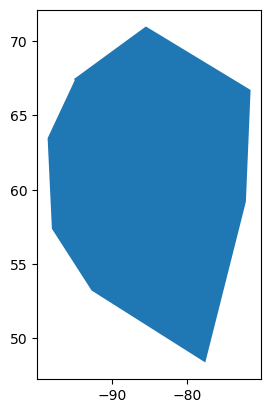

In [11]:
#plot Canadian shield as polygon
gdf.plot()

<Axes: >

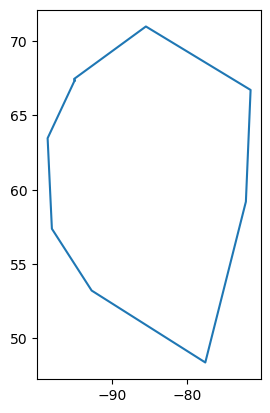

In [12]:
#plot the boundary
gdf.boundary.plot()

In [13]:
from ipywidgets import widgets, interact
names = list(df.keys() )

In [14]:
inds = df['BOUGUER'].values<2000.

In [15]:
def foo(name, n_skip):
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    out = ax.scatter(
        xy[inds,0][::n_skip], xy[inds,1][::n_skip], s=1, c=df[name].values[inds][::n_skip], 
        cmap='turbo', 
        # vmin=-215.6, vmax=242.6
    )
    gdf.boundary.plot(ax=ax, color='red')
    plt.colorbar(out)
    ax.set_aspect(1)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(name)
    
interact(foo, name=widgets.Select(options=names, value='BOUGUER'), n_skip=widgets.IntSlider(min=1, max=20, step=1, value=5))

interactive(children=(Select(description='name', index=4, options=('X', 'Y', 'ADJG', 'B_ERR', 'BOUGUER', 'COOR…

<function __main__.foo(name, n_skip)>

In [17]:
def get_normal_gravity(phi_degree, e2=0.00669438002290, k=0.001931851353, gamma_e=978032.67715):
    phi = np.deg2rad(phi_degree)
    sin2 = np.sin(phi)**2
    gamma_phi = gamma_e * (1+k*sin2) / (np.sqrt(1-e2*sin2))
    return gamma_phi

In [18]:
free_air_correction = get_normal_gravity(xy[:,1])  - 0.3086 * df['ELEV'].values


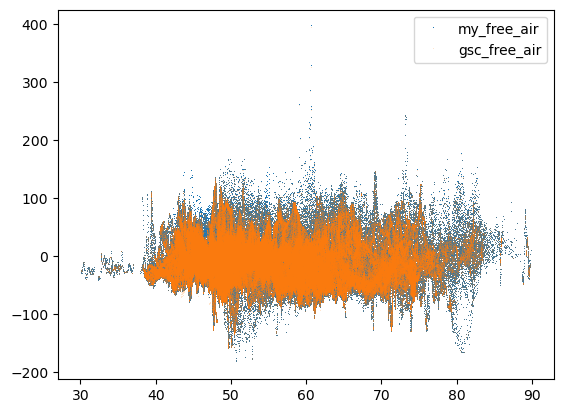

In [19]:
plt.plot(xy[:,1], df['ADJG'].values-free_air_correction, ',', label='my_free_air')
plt.plot(xy[:,1], df['FREEAIR'].values, ',', alpha=0.2, label='gsc_free_air')
plt.legend()

In [20]:
free_air_anomaly = df['ADJG'].values-free_air_correction

Text(673.608962213823, 0.5, 'Latitude')

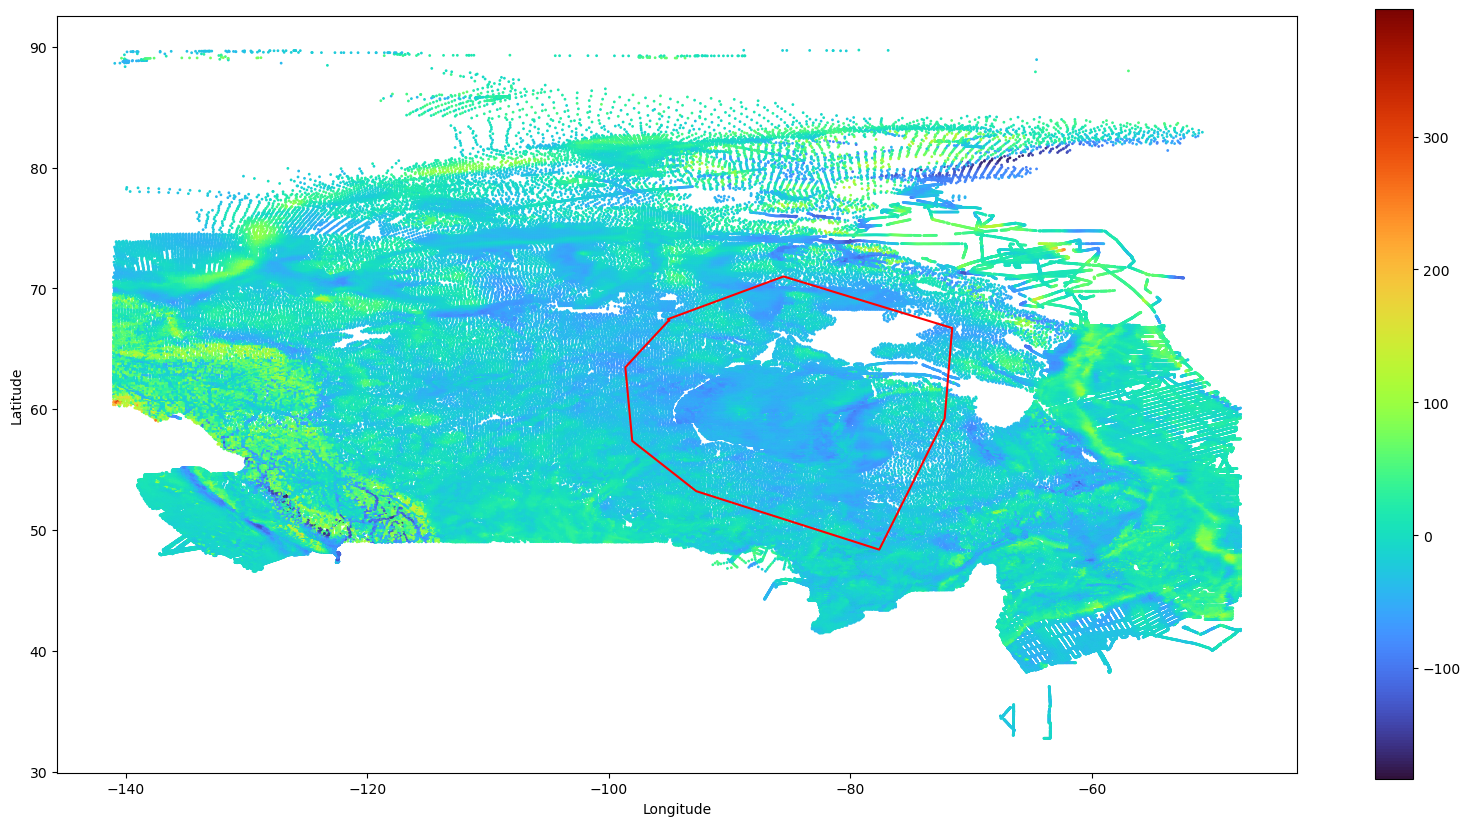

In [21]:
n_skip = 1
fig, ax = plt.subplots(1,1, figsize=(20, 10))
out = ax.scatter(
    xy[inds,0][::n_skip], xy[inds,1][::n_skip], s=1, c=free_air_anomaly[inds][::n_skip], 
    cmap='turbo', 
    # vmin=-215.6, vmax=242.6
)
gdf.boundary.plot(ax=ax, color='red')
plt.colorbar(out)
ax.set_aspect(1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [71]:
#!pip install verde

In [24]:
points = gpd.points_from_xy(xy[:,0], xy[:,1], crs=4326)
gdf_points = gpd.GeoDataFrame(data={}, geometry=points)

In [25]:
gdf_points_clipped = gdf_points.clip(gdf)

In [26]:
inds_within_polygon = np.array(list(gdf_points_clipped.index))

<Axes: >

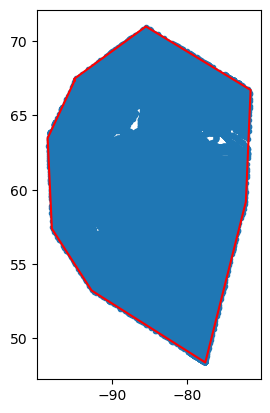

In [27]:
fig, ax = plt.subplots(1,1)
# gdf_points_clipped.plot(markersize=1, ax=ax)
ax.plot(xy[inds_within_polygon,0], xy[inds_within_polygon,1], '.')
gdf.boundary.plot(ax=ax, color='r')

In [29]:
from scipy.spatial import cKDTree as KDTree
from verde import distance_mask
def inverse_distance_interpolation(
    xy, values, 
    dx=100, dy=100, x_pad=1000, y_pad=1000,
    power=0, epsilon=None, k_nearest_points=20, 
    max_distance=4000.,
):
    """
        Evaluating 2D inverse distance weighting interpolation
        for given (x, y) points and values.
        
        Inverse distance weight, w, can be written as:
            w = 1/(distance+epsilon)**power
        
        Parameters
        ----------
        xy : array_like
            Input array including (x, y) locations; (n_locations, 2)
        values: array_like
            Input array including values defined at (x, y) locations; (n_locations, )
        dx : int 
            Size of the uniform grid in x-direction
        dy : int 
            Size of the uniform grid in y-direction
        x_pad : float 
            Length of padding in x-direction
        y_pad : float 
            Length of padding in y-direction
        power: float
            Exponent used when evaluating inverse distance weight. 
        epsilon: float
            A floor value used when evaluating inverse distance weight. 
        k_nearest_points: int 
            k-nearest-point used when evaluating inverse distance weight.  
        max_distance: float
            A separation distance used to maks grid points away from the (x, y) locations.
        
        Returns        
        -------
        

    """
    xmin, xmax = xy[:,0].min()-x_pad, xy[:,0].max()+x_pad
    ymin, ymax = xy[:,1].min()-y_pad, xy[:,1].max()+y_pad

    nx = int((xmax-xmin) / dx)
    ny = int((ymax-ymin) / dy)
    hx = np.ones(nx) * dx
    hy = np.ones(ny) * dy
    x = np.arange(nx)*dx + xmin
    y = np.arange(ny)*dy + ymin
    X, Y = np.meshgrid(x, y)

    tree = KDTree(xy)

    d, inds_idw = tree.query(np.c_[X.flatten(), Y.flatten()], k=int(k_nearest_points))
    if epsilon is None:
        epsilon = np.min([dx, dy])
    w = 1.0 / ((d+epsilon) ** power)
    values_idw = (np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1))
    mask_inds = ~distance_mask(
        (xy[:,0], xy[:,1]), maxdist=max_distance, coordinates=(X.flatten(), Y.flatten())
    )
    values_idw[mask_inds] = np.nan
    values_idw = values_idw.reshape(X.shape)
    return x, y, values_idw

In [30]:
gdf_points_clipped.to_file("./hudson_bay_points.geojson")

In [31]:
dx=0.01
dy=0.01
x, y, values_idw = inverse_distance_interpolation(xy[inds_within_polygon,:], free_air_anomaly[inds_within_polygon], x_pad=0.2, y_pad=0.2, dx=dx, dy=dy, max_distance=0.5, k_nearest_points=12, power=2)
xmin = x.min()
ymin = y.min()
crs = int(4326)
nx = len(x)
ny = len(y)

Text(0.5, 1.0, 'Free air anomaly for Thunder Bay area')

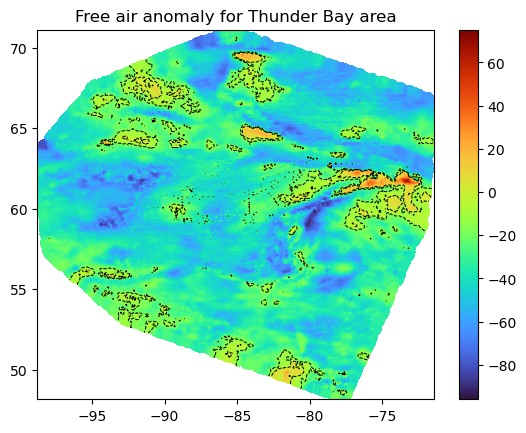

In [32]:
out = plt.pcolormesh(x, y, values_idw, cmap='turbo')
plt.contour(x, y, values_idw, levels=[-15, -2], colors='k', linestyles=['--', '--'], linewidths=0.7)
plt.colorbar(out)
plt.title("Free air anomaly for Thunder Bay area")

In [33]:
#!pip install emrecharge
from emrecharge.gis import export_to_tif

In [34]:
filename = './hudson_bay_test'
export_to_tif(values_idw, dx, dy, xmin, ymin, int(4326), f'{filename}.tif')